In [1]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
subj = 1
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

from torch.utils.data import Dataset
from src.file_utility import load_mask_from_nii, view_data
from src.file_utility import save_stuff, flatten_dict, embed_dict



import struct
import time
from scipy.io import loadmat
from scipy.stats import pearsonr
import pickle
import math
%matplotlib inline
fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi
from src.load_nsd import  image_feature_fn, data_split
import h5py
import glob
import torchvision.models as models
from sklearn.decomposition import PCA
from PIL import Image
from src.numpy_utility import mosaic_vis, iterate_minibatches
from nilearn.decoding import SpaceNetRegressor
import nibabel as nib

device: cpu


AttributeError: module 'typing' has no attribute 'Literal'

In [3]:
subj =1
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subj)
voxel_roi_full.shape

(81, 104, 83)

In [4]:
# from NSDAccess import NSDAccess
# nsd = NSDAccess('/scratch/cl6707/Projects/neuro_interp/data/NSD/')

if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386

In [5]:
print('Pulling NSD webdataset data...')
# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)



train_url = "{" + f"{data_path}/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar," + f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" + "}"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
print(train_url,"\n",val_url)
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 64
print('Prepping train and validation dataloaders...')
train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=300,
    cache_dir=data_path, #"/tmp/wds-cache",
    seed=seed,
    voxels_key='nsdgeneral.npy', # 'nsdgeneral.npy' (1d), 'wholebrain_3d.npy'(3d)
    to_tuple=["voxels", "images", "coco","trial"],
    local_rank=local_rank,
    world_size=world_size,
)

Pulling NSD webdataset data...
PID of this process = 1111297
device: cpu
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cpu

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
{/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/train/train_subj01_{0..17}.tar,/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/val/val_subj01_0.tar} 
 /scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/test/test_subj01_{0..1}.tar
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 64
batch_size 64
num_workers 1
num_batches 138
num_worker_batches 138

num_val 982
val_num_batches 15
val_batch_size 300


In [6]:
file_path = '/scratch/cl6707/Projects/neuro_interp/new_dataloader.pkl'

with open(file_path, 'rb') as file:
    train_dl = pickle.load(file)

train_iterator = iter(train_dl)
features_list = []

for i in range(num_train):
    sample = next(train_iterator)
    
    voxels, images, coco, trial, feature = sample
    
    features_list.append(feature.item())


In [5]:
def reconstruct_volume_corrected(vol_shape, binary_mask, data_vol, order='C'):
    
    view_vol = np.ones(np.prod(vol_shape), dtype=np.float32) * np.nan
    
    idx_mask = np.where(binary_mask)[0]
    
    view_vol[idx_mask] = data_vol
    return view_vol.reshape(vol_shape, order=order)

In [8]:
train_iterator = iter(train_dl)
nii_list = []
nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').get_fdata()==1


for i in range(num_train):
    sample = next(train_iterator)
    voxels, images, coco, trial, feature = sample
    voxels = voxels[0,0].cpu().numpy()
    reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
    reconstructed = np.nan_to_num(reconstructed)
    #ori_mask = np.array(np.where(nsdgeneral_roi_mask==1)).T
    #recon_mask = np.array(np.where(reconstructed!=0)).T
    #for i in range(ori_mask.shape[0]):
        #assert np.all(ori_mask[i]==recon_mask[i])
    
    ni_img = nib.Nifti1Image(reconstructed,affine=nsdgeneral_affine)
    nii_list.append(ni_img)

In [9]:
decoder = SpaceNetRegressor(
    memory="nilearn_cache",
    penalty="graph-net",
    screening_percentile=5.0,
    memory_level=2,
    standardize="zscore_sample",
)

In [10]:
decoder.fit(nii_list, features_list) 
coef_img = decoder.coef_img_

[NiftiMasker.fit] Loading data from [Nifti1Image(
shape=(81, 104, 83),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
),
 Nifti1Image(
shape=(81, 104, 83),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
),
 Nifti1Image(
shape=(81, 104, 83),
affine=array([[  1.79999995,   0.        ,   0.        , -72.        ],
       [  0.        ,   1.79999995,   0.        , -92.69999695],
       [  0.        ,   0.        ,   1.79999995, -73.80000305],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
),
 Nifti1Image(
shape=(81, 104, 83),
affine=arra

/scratch/ne2213/projects/tmp_packages/nilearn/maskers/nifti_masker.py:558: UserWarning: Persisting input arguments took 80.36s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([1108, ..., 8858]), array([   0, ..., 1107]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 0), debias=False, verbose=1, screening_percentile=99.62900550268421)


...../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.61s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 254.0s, 4.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 8858]), array([1108, ..., 2215]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 1), debias=False, verbose=1, screening_percentile=99.62900550268421)


..../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.61s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 258.7s, 4.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 8858]), array([2216, ..., 3323]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 2), debias=False, verbose=1, screening_percentile=99.62900550268421)


...../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.61s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 257.4s, 4.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 8858]), array([3324, ..., 4430]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 3), debias=False, verbose=1, screening_percentile=99.62900550268421)


...../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.61s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 258.3s, 4.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 8858]), array([4431, ..., 5537]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 4), debias=False, verbose=1, screening_percentile=99.62900550268421)


...../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.62s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 253.0s, 4.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 8858]), array([5538, ..., 6644]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 5), debias=False, verbose=1, screening_percentile=99.62900550268421)


...../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.61s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 252.7s, 4.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 8858]), array([6645, ..., 7751]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 6), debias=False, verbose=1, screening_percentile=99.62900550268421)


...../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.61s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 255.1s, 4.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x154eca62b310>, array([[-0.671995, ...,  0.370864],
       ...,
       [-0.532084, ...,  0.080202]]), 
array([0.016505, ..., 0.011129]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 7751]), array([7752, ..., 8858]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=False, key=(0, 7), debias=False, verbose=1, screening_percentile=99.62900550268421)


...../scratch/ne2213/projects/tmp_packages/joblib/parallel.py:1792: UserWarning: Persisting input arguments took 1.61s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  res = func(*args, **kwargs)


____________________________________________________path_scores - 257.0s, 4.3min
Time Elapsed: 2422.2176990509033 seconds, 40.37029498418172 minutes.


In [11]:
folder_path = '/scratch/ne2213/projects/IVP/Neural_Interpretation-main/notebooks'
file_path = folder_path + '/new_val_dataloader.pkl'

with open(file_path, 'rb') as file:
    val_dl = pickle.load(file)
    
val_iterator = iter(val_dl)
nii_val_list = []


for i in range(num_val):
    try: 
        sample = next(val_iterator)
    except StopIteration:
        # Handle the end of iteration, if needed
        break
    voxels, images, coco, trial, feature = sample
    voxels = voxels[0,0].cpu().numpy()
    nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').get_fdata()==1
    reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
    reconstructed = np.nan_to_num(reconstructed)

    nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
    
    ori_mask = np.array(np.where(nsdgeneral_roi_mask==1)).T
    recon_mask = np.array(np.where(reconstructed!=0)).T
    for i in range(ori_mask.shape[0]):
        assert np.all(ori_mask[i]==recon_mask[i])
    
    ni_img = nib.Nifti1Image(reconstructed,affine=nsdgeneral_affine)
    nii_val_list.append(ni_img)

In [14]:
folder_path = '/scratch/ne2213/projects/IVP/Neural_Interpretation-main/notebooks'
file_path = folder_path + '/new_val_dataloader.pkl'

with open(file_path, 'rb') as file:
    val_dl = pickle.load(file)
    
val_iterator = iter(val_dl)

features_val_list = []

for i in range(num_val):
    try: 
        sample = next(val_iterator)
    except StopIteration:
        # Handle the end of iteration, if needed
        break
        
    voxels, images, coco, trial, feature = sample
    
    features_val_list.append(feature.item())


In [17]:
y_pred = decoder.predict(nii_val_list).ravel()  # predict
mse = np.mean(np.abs(features_val_list - y_pred))
print(f"Mean square error (MSE) on the features: {mse:.8f}")

Mean square error (MSE) on the features: 0.00315900


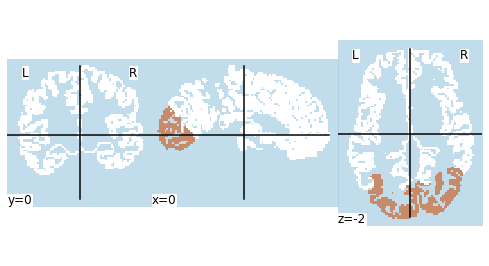

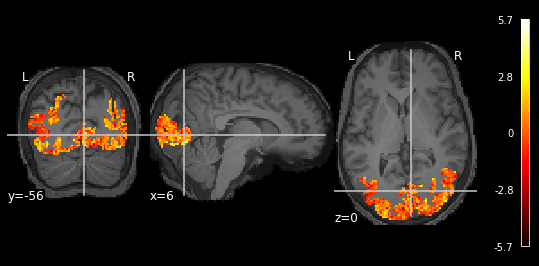

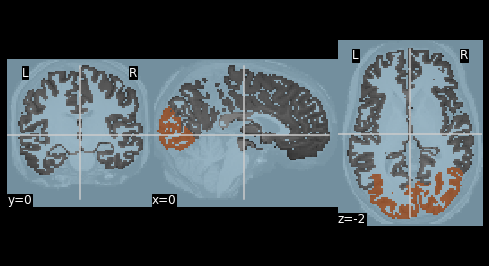

In [18]:
from nilearn import plotting

nsdgeneral = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz'
anat_img = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/T1_to_func1pt8mm.nii.gz'

ni_img = nii_list[0]

plotting.plot_roi(nsdgeneral,
                    bg_img=None,
                    cmap='Paired')
plotting.plot_stat_map(ni_img,
                    bg_img=anat_img,
                    cmap='hot')
plotting.plot_roi(nsdgeneral,
                    bg_img=anat_img,
                    cmap='Paired')

/scratch/ne2213/projects/tmp_packages/nilearn/plotting/displays/_slicers.py:1457: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes(


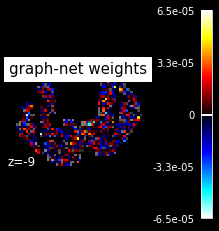

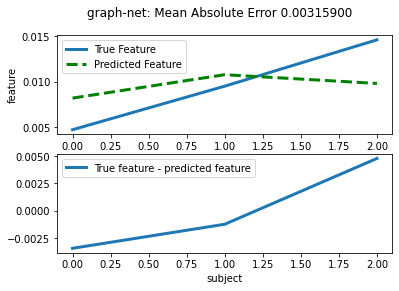

In [20]:
from nilearn.plotting import plot_stat_map, show

# weights map
background_img = nii_val_list[0]
plot_stat_map(
    coef_img,
    background_img,
    title="graph-net weights",
    display_mode="z",
    cut_coords=1,
)

# Plot the prediction errors.
import matplotlib.pyplot as plt

plt.figure()
plt.suptitle(f"graph-net: Mean Absolute Error {mse:.8f}")
linewidth = 3
ax1 = plt.subplot(211)
ax1.plot(features_val_list, label="True Feature", linewidth=linewidth)
ax1.plot(y_pred, "--", c="g", label="Predicted Feature", linewidth=linewidth)
ax1.set_ylabel("feature")
plt.legend(loc="best")
ax2 = plt.subplot(212)
ax2.plot(
    features_val_list - y_pred, label="True feature - predicted feature", linewidth=linewidth
)
ax2.set_xlabel("subject")
plt.legend(loc="best")

show()

## SpaceNet Classifier or maybe semantic?

In [10]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
nsd_mindroot = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'

annotation = np.load(nsd_mindroot + '/subj%02d_annot.npy'%subj,allow_pickle=True)
things = np.load(nsd_mindroot + '/subj%02d_things.npy'%subj,allow_pickle=True)
for voxels, images, coco, trial  in tqdm(train_dl):
    print(voxels.shape)
    print(images.shape)
    print(coco.shape)
    print(trial.shape)
    print(things[trial[0]])
    print(annotation[trial[0]])
    break

0it [00:02, ?it/s]

torch.Size([1, 3, 15724])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1])
torch.Size([1, 1])
['appliance', 'electronic']
['A refrigerator with a couple bags next to it.', 'A small refrigerator and a rice maker on a table in a kitchen', 'a icebox that has some stuff on top of it', 'a kitchen with a refrigerator near a counter ', 'Old school refrigerator with clutter atop of it and to the side.']


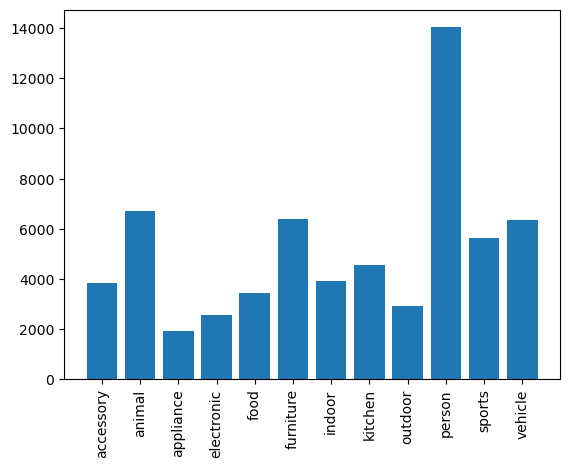

In [22]:
things_all = np.concatenate(things, axis=0)
unique_things = np.unique(things_all,return_counts=True)
plt.bar(unique_things[0],unique_things[1])
plt.xticks(rotation=90)
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
guse = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

0it [00:00, ?it/s]

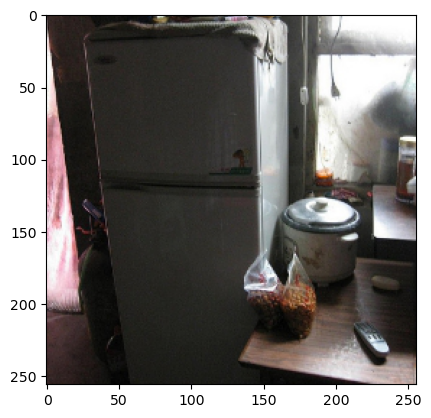

['appliance', 'electronic']
['A refrigerator with a couple bags next to it.', 'A small refrigerator and a rice maker on a table in a kitchen', 'a icebox that has some stuff on top of it', 'a kitchen with a refrigerator near a counter ', 'Old school refrigerator with clutter atop of it and to the side.']
0
A refrigerator with a couple bags next to it.


0it [00:03, ?it/s]


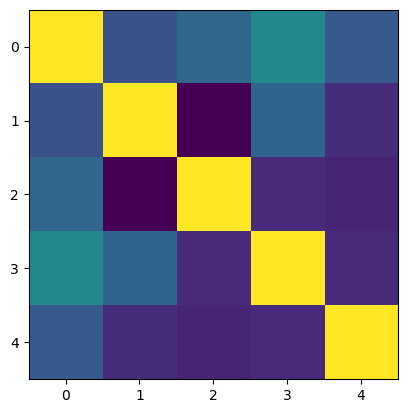

In [65]:

for voxels, images, coco, trial  in tqdm(train_dl):
   # show images
   plt.imshow(images[0].cpu().numpy().transpose(1,2,0))
   plt.show()
   print(things[trial[0]])
   print(annotation[trial[0]])
   annot_embed = guse(annotation[trial[0]]).numpy()
   
   #confusion matrix
   corr_mat = np.corrcoef(annot_embed)
   plt.imshow(corr_mat)
   max_index = np.argmax(corr_mat.mean(axis=0),axis=0)
   print(max_index)
   print(annotation[trial[0]][max_index])

   break

In [48]:
nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').get_fdata()==1
def voxel2nii(voxels):
    reconstructed = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxels)
    reconstructed = np.nan_to_num(reconstructed)
    ni_img = nib.Nifti1Image(reconstructed,affine=nsdgeneral_affine)
    return ni_img

In [51]:
train_nii_list = []
train_guse_list = []
val_nii_list = []
val_guse_list = []

for voxels, images, coco, trial  in tqdm(train_dl):
    B = voxels.shape[0]
    for b in range(B):
        train_nii_list.append(voxel2nii(voxels[b,0].cpu().numpy()))
        train_guse_list.append(guse(annotation[trial[b]]).numpy().mean(axis=0))

for voxels, images, coco, trial  in tqdm(val_dl):
    B = voxels.shape[0]
    for b in range(B):
        val_nii_list.append(voxel2nii(voxels[b,0].cpu().numpy()))
        val_guse_list.append(guse(annotation[trial[b]]).numpy().mean(axis=0))
    

0it [00:00, ?it/s]

8859it [01:43, 85.59it/s]
3it [00:08,  2.94s/it]


In [68]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, graph_structure, lambda_g, lambda_tv):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.graph_structure = graph_structure
        self.lambda_g = lambda_g
        self.lambda_tv = lambda_tv

    def forward(self, x):
        return self.linear(x)

    def graphnet_regularization(self):
        weights = self.linear.weight
        regularization_term = torch.sum((weights @ self.graph_structure) * weights)
        return self.lambda_g * regularization_term

    def tv_regularization(self):
        weights = self.linear.weight
        tv_norm = torch.sum(torch.abs(weights[:, 1:] - weights[:, :-1])) + \
                  torch.sum(torch.abs(weights[1:, :] - weights[:-1, :]))
        return self.lambda_tv * tv_norm



def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = torch.nn.functional.mse_loss(output, target) + \
               model.graphnet_regularization() + \
               model.tv_regularization()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tMSE Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += torch.nn.functional.mse_loss(output, target, reduction='sum').item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average MSE loss: {:.4f}\n'.format(test_loss))

    return test_loss



In [1]:
input_size = num_voxels
output_size = 512
lambda_g = 0.1
lambda_tv = 0.1

model = LinearModel(input_size, output_size, graph_structure, lambda_g, lambda_tv)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epoch = 20
annotation_all = np.load(nsd_mindroot + '/subj%02d_annot.npy'%subj,allow_pickle=True)
def get_guse(annotation):
    B = trial.shape[0]
    annot_embed_all = np.zeros((B,512))
    print(B)
    for b in range(B):
        annot_embed = guse(annotation[b][0]).numpy()
        corr_mat = np.corrcoef(annot_embed)
        max_index = np.argmax(corr_mat.mean(axis=0),axis=0)
        annot_embed_all[b] = annot_embed[max_index]
    
    return torch.tensor(annot_embed_all).to(device)

for voxels, images, coco, trial  in tqdm(train_dl):
    embedding = get_guse(annotation)
    train(model, train_loader, optimizer, epoch)
    break

NameError: name 'num_voxels' is not defined